In [1]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(0)

# Bandit
## sum

In [2]:
rewards = []

for n in range(1, 11):
    reward = np.random.rand()
    rewards.append(reward)
    Q = sum(rewards) / n
    print(f"n = {n}, Q = {Q}")

n = 1, Q = 0.5488135039273248
n = 2, Q = 0.6320014351498722
n = 3, Q = 0.6222554154571295
n = 4, Q = 0.6029123573420713
n = 5, Q = 0.567060845741438
n = 6, Q = 0.5801997236289743
n = 7, Q = 0.5598265075766483
n = 8, Q = 0.6013198192273272
n = 9, Q = 0.6415801460355164
n = 10, Q = 0.6157662833145425


## incrementally update Q

In [6]:
np.random.seed(0)
Q = 0

for n in range(1, 11):
    reward = np.random.rand()
    Q += (reward - Q) / n
    print(f"n = {n}, Q = {Q}")

n = 1, Q = 0.5488135039273248
n = 2, Q = 0.6320014351498722
n = 3, Q = 0.6222554154571294
n = 4, Q = 0.6029123573420713
n = 5, Q = 0.567060845741438
n = 6, Q = 0.5801997236289743
n = 7, Q = 0.5598265075766483
n = 8, Q = 0.6013198192273272
n = 9, Q = 0.6415801460355164
n = 10, Q = 0.6157662833145425


## Create Bandit class

In [42]:
class Bandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.rates = np.random.rand(arms)
    
    def play(self, arm):
        rate = self.rates[arm]
        if rate > np.random.rand():
            return 1
        else:
            return 0

## test bandit
bandit = Bandit()
for _ in range(3):
    print(bandit.play(0))

1
0
0


## Create Bandit Agent

In [24]:
bandit = Bandit()
Qs = np.zeros(10)
ns = np.zeros(10)
Qss = []

for n in range(1, 1001):
    action = np.random.randint(0, 10)
    reward = bandit.play(action)

    ns[action] += 1
    Qs[action] += (reward - Qs[action]) / ns[action]
    Qss.append(Qs.copy())

print(Qs)
print(bandit.rates)

[0.63302752 0.30555556 0.33707865 0.11403509 0.1559633  0.91836735
 0.87234043 0.57303371 0.10989011 0.68686869]
[0.62390169 0.28982136 0.37896842 0.1173766  0.09658314 0.91131412
 0.82661591 0.5787672  0.09451203 0.68716411]


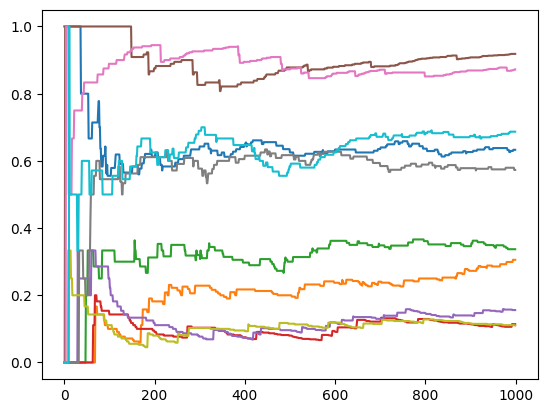

In [25]:
plt.plot(Qss)

In [26]:
class Agent:
    def __init__(self, epsilon, action_size=10):
        self.epsilon = epsilon
        self.Qs = np.zeros(action_size)
        self.ns = np.zeros(action_size)
    
    def update(self, action, reward):
        self.ns[action] += 1
        self.Qs[action] += (reward - self.Qs[action]) / self.ns[action]
    
    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.Qs))
        else:
            return np.argmax(self.Qs)

595


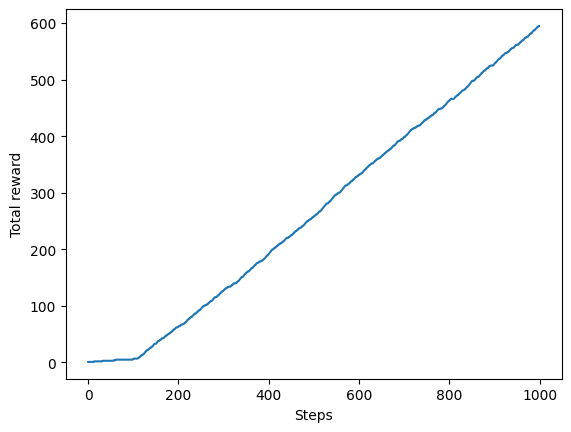

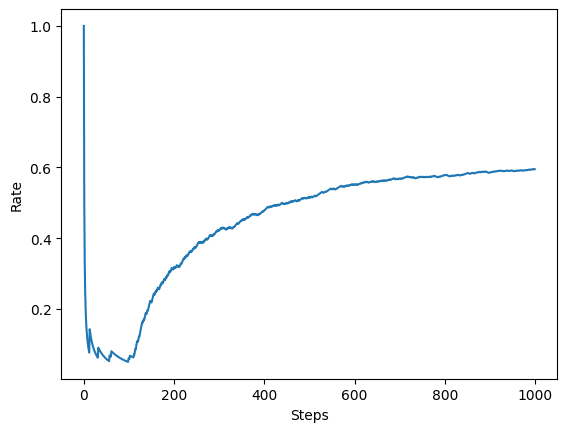

In [29]:
steps = 1000
epsilon = 0.1

bandit = Bandit()
agent = Agent(epsilon)
total_reward = 0
total_rewards = []
rates = []

for step in range(steps):
    action = agent.get_action() # select action
    reward = bandit.play(action) # play bandit
    agent.update(action, reward) # learn

    total_reward += reward

    total_rewards.append(total_reward) # for plot
    rates.append(total_reward / (step + 1))

print(total_reward)

plt.ylabel("Total reward")
plt.xlabel("Steps")
plt.plot(total_rewards)
plt.show()

plt.ylabel("Rate")
plt.xlabel("Steps")
plt.plot(rates)
plt.show()

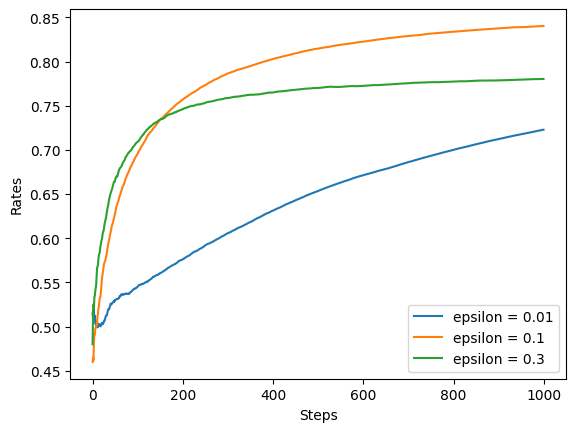

In [34]:
runs = 200
steps = 1000
epsilon_rates = []

for epsilon in [0.01, 0.1, 0.3]:
    all_rates = np.zeros((runs, steps))  # (2000, 1000)

    for run in range(runs):
        bandit = Bandit()
        agent = Agent(epsilon)
        total_reward = 0
        rates = []

        for step in range(steps):
            action = agent.get_action()
            reward = bandit.play(action)
            agent.update(action, reward)
            total_reward += reward
            rates.append(total_reward / (step + 1))

        all_rates[run] = rates

    avg_rates = np.average(all_rates, axis=0)
    epsilon_rates.append(avg_rates)

plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(epsilon_rates[0], label='epsilon = 0.01')
plt.plot(epsilon_rates[1], label='epsilon = 0.1')
plt.plot(epsilon_rates[2], label='epsilon = 0.3')
plt.legend()
plt.show()

## non state bandit

In [43]:
class NonStateBnadit(Bandit):
    def play(self, arm):
        ret = super().play(arm)
        self.rates += 0.1 * np.random.randn(self.arms) # add noise
        return ret

In [44]:
class AlphaAgent(Agent):
    def __init__(self, alpha, action_size=10):
        self.epsilon = epsilon
        self.Qs = np.zeros(action_size)
        self.alpha = alpha
    
    def update(self, action, reward):
        self.Qs[action] += self.alpha * (reward - self.Qs[action])

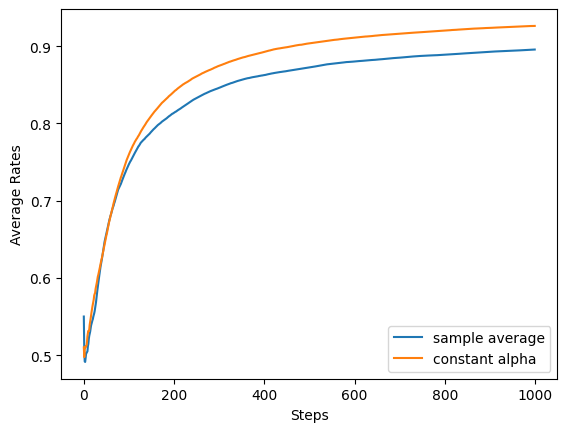

In [45]:
runs = 200
steps = 1000
epsilon = 0.1
alpha = 0.8
agent_types = ["sample average", "constant alpha"]
results = {}

for agent_type in agent_types:
    all_rates = np.zeros((runs, steps))

    for run in range(runs):
        if agent_type == "sample average":
            agent = Agent(epsilon)
        else:
            agent = AlphaAgent(alpha)

        bandit = NonStateBnadit()
        total_reward = 0
        rates = []

        for step in range(steps):
            action = agent.get_action()
            reward = bandit.play(action)
            agent.update(action, reward)
            total_reward += reward
            rates.append(total_reward / (step + 1))

        all_rates[run] = rates

    avg_rates = np.average(all_rates, axis=0)
    results[agent_type] = avg_rates

plt.figure()
plt.ylabel("Average Rates")
plt.xlabel("Steps")
for key, avg_rates in results.items():
    plt.plot(avg_rates, label=key)
plt.legend()
plt.show()